In [22]:
# Cell 1 (Corrected)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# --- THIS IS THE MODIFIED LINE ---
from scipy.spatial.transform import Rotation as R, Slerp
# ---------------------------------

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# We can re-use the transformation matrix functions from our last project
def rotation_y(theta):
    c = np.cos(theta); s = np.sin(theta)
    return np.array([[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]])

def rotation_z(theta):
    c = np.cos(theta); s = np.sin(theta)
    return np.array([[c, -s, 0, 0], [s, c, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def translation(x, y, z):
    return np.array([[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]])

print("Imports and helper functions are ready (with Slerp included).")

Imports and helper functions are ready (with Slerp included).


In [23]:
# Cell 2: The 6-DOF Forward Kinematics Function

def forward_kinematics_6dof(thetas, links):
    """
    Calculates the 3D position and orientation of a 6-DOF arm.
    thetas = [theta1, theta2, theta3, theta4, theta5, theta6] in radians
    links = [L1, L2]
    """
    theta1, theta2, theta3, theta4, theta5, theta6 = thetas
    L1, L2 = links
    
    # Base
    T_0_1 = rotation_z(theta1)
    
    # Shoulder
    T_1_2 = T_0_1 @ rotation_y(theta2)
    
    # Elbow (after Link 1)
    T_2_3 = T_1_2 @ translation(0, 0, L1) @ rotation_y(theta3)
    
    # Wrist Center (after Link 2)
    T_3_4 = T_2_3 @ translation(0, 0, L2)
    
    # Wrist Orientation
    T_4_5 = T_3_4 @ rotation_z(theta4)
    T_5_6 = T_4_5 @ rotation_y(theta5)
    T_6_7 = T_5_6 @ rotation_z(theta6) # Final transformation
    
    T_final = T_6_7

    # --- Extract positions and orientation ---
    
    # Joint positions for plotting
    p0 = np.array([0, 0, 0])
    p1 = T_2_3[:3, 3]  # Position of the elbow
    p2 = T_3_4[:3, 3]  # Position of the wrist center
    p_hand = T_final[:3, 3] # Position of the hand/end-effector
    
    # Final orientation of the hand
    orientation_matrix = T_final[:3, :3]
    
    return p0, p1, p2, p_hand, orientation_matrix

print("6-DOF Forward Kinematics function defined.")

6-DOF Forward Kinematics function defined.


Hand Position: [1.03656609 1.03656609 1.12484445]
Hand Orientation Matrix:
[[-0.36265517 -0.67770127  0.63968916]
 [ 0.21327863  0.60784461  0.76487722]
 [-0.90718987  0.4138187  -0.07589879]]


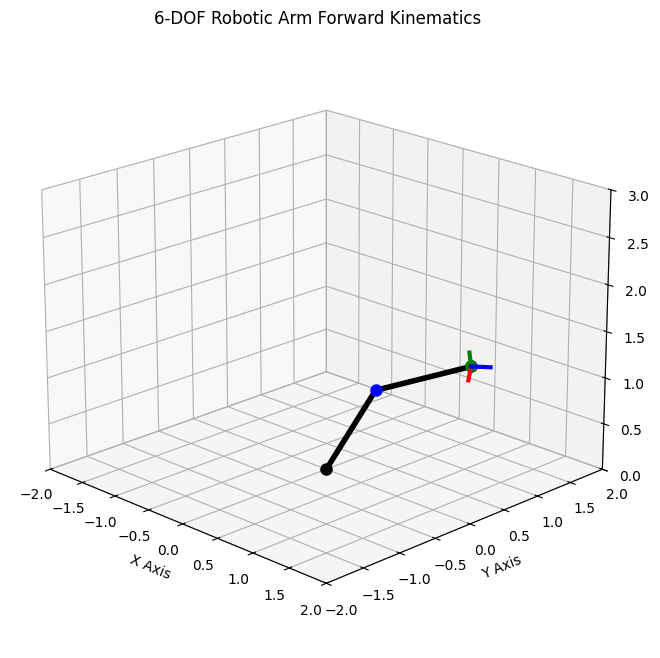

In [24]:
# Cell 3: Test and Visualize the 6-DOF Forward Kinematics

# --- Define Arm and Angles ---
link_lengths = [1.0, 1.0] # L1, L2
angles_deg = [45, 30, 45, 15, 20, 10] # theta1 to theta6
angles_rad = np.deg2rad(angles_deg)

# --- Calculate Joint Positions and Orientation ---
p0, p1, p2, p_hand, R_hand = forward_kinematics_6dof(angles_rad, link_lengths)

print(f"Hand Position: {p_hand}")
print(f"Hand Orientation Matrix:\n{R_hand}")

# --- Plotting ---
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the links
ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'k-', lw=4)
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', lw=4)

# Plot the joints
ax.plot([p0[0]], [p0[1]], [p0[2]], 'o', color='black', markersize=8)
ax.plot([p1[0]], [p1[1]], [p1[2]], 'o', color='blue', markersize=8)
ax.plot([p2[0]], [p2[1]], [p2[2]], 'o', color='blue', markersize=8)
ax.plot([p_hand[0]], [p_hand[1]], [p_hand[2]], 'o', color='green', markersize=8)

# --- Visualize the Hand's Orientation ---
axis_length = 0.2
# The columns of the rotation matrix are the new X, Y, and Z vectors
x_axis = R_hand[:, 0]
y_axis = R_hand[:, 1]
z_axis = R_hand[:, 2]

# Plot the hand's coordinate frame
ax.plot([p_hand[0], p_hand[0] + axis_length * x_axis[0]], [p_hand[1], p_hand[1] + axis_length * x_axis[1]], [p_hand[2], p_hand[2] + axis_length * x_axis[2]], 'r-', lw=3)
ax.plot([p_hand[0], p_hand[0] + axis_length * y_axis[0]], [p_hand[1], p_hand[1] + axis_length * y_axis[1]], [p_hand[2], p_hand[2] + axis_length * y_axis[2]], 'g-', lw=3)
ax.plot([p_hand[0], p_hand[0] + axis_length * z_axis[0]], [p_hand[1], p_hand[1] + axis_length * z_axis[1]], [p_hand[2], p_hand[2] + axis_length * z_axis[2]], 'b-', lw=3)

# Setting labels and limits
ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
ax.set_title('6-DOF Robotic Arm Forward Kinematics')
ax.set_xlim([-2, 2]); ax.set_ylim([-2, 2]); ax.set_zlim([0, 3])
ax.view_init(elev=20., azim=-45) # Set a nice viewing angle
plt.show()

In [25]:
# Cell 4: The Combined Position and Orientation Error Function

def combined_error_function(thetas, target_pos, target_ori_R, links, weights):
    """
    Calculates a combined error for both position and orientation.
    target_ori_R: The target orientation as a SciPy Rotation object.
    weights: A tuple (w_pos, w_ori) for weighting the errors.
    """
    # Calculate the current position and orientation of the hand
    p0, p1, p2, p_hand, R_hand = forward_kinematics_6dof(thetas, links)
    
    # --- Calculate Position Error ---
    position_error = np.linalg.norm(p_hand - target_pos)
    
    # --- Calculate Orientation Error ---
    # Convert current orientation matrix to a SciPy Rotation object
    R_current = R.from_matrix(R_hand)
    
    # Calculate the rotational difference (error) between the two orientations
    # The result is another rotation object
    error_rotation = target_ori_R * R_current.inv()
    
    # Get the magnitude of this rotation in radians.
    # A value of 0 means the orientations are identical.
    orientation_error = error_rotation.magnitude()
    
    # --- Calculate Total Weighted Error ---
    w_pos, w_ori = weights
    total_error = (w_pos * position_error) + (w_ori * orientation_error)
    
    return total_error

print("Combined error function defined.")

Combined error function defined.


In [26]:
# Cell 5 (Upgraded to accept an initial guess)

def inverse_kinematics_6dof(target_pos, target_ori_R, links, initial_guess=None):
    """
    Finds the joint angles for a target position AND orientation.
    Now accepts an initial_guess to guide the search.
    """
    # If no initial guess is provided, start from zeros
    if initial_guess is None:
        initial_guess = np.zeros(6) 
    
    # Set bounds for each joint angle (e.g., -180 to 180 degrees)
    bounds = [(-np.pi, np.pi)] * 6
    
    # Set weights for position vs. orientation error
    weights = (1.0, 0.5) 

    # Call the optimizer
    result = minimize(
        combined_error_function,
        initial_guess, # Use the provided initial guess
        args=(target_pos, target_ori_R, links, weights), 
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': 2000}
    )
    
    if result.success:
        return result.x
    else:
        # Don't print a failure message for every step, just return None
        return None

print("6-DOF Inverse Kinematics solver upgraded to accept an initial guess.")

6-DOF Inverse Kinematics solver upgraded to accept an initial guess.


In [27]:
# Cell 6: Test Drive the 6-DOF Inverse Kinematics

# --- 1. Define a Target Position and Orientation ---
target_position = np.array([0.5, 0.8, 1.2])

# Define a target orientation. 
# Let's aim for the hand to be pointing 45 degrees down (a rotation around the Y-axis)
# and rotated 30 degrees around its own axis (Z-axis).
target_ori_R = R.from_euler('zy', [-30, 45], degrees=True)

# For verification later, get the target orientation as a matrix
target_ori_matrix = target_ori_R.as_matrix()

print(f"Target Position: {target_position}")
print(f"Target Orientation Matrix:\n{target_ori_matrix}\n")


# --- 2. Solve for Joint Angles ---
print("Solving for 6-DOF inverse kinematics...")
optimal_angles_rad = inverse_kinematics_6dof(target_position, target_ori_R, link_lengths)


# --- 3. Verification Step ---
if optimal_angles_rad is not None:
    print(f"\nOptimal Angles (degrees): {np.rad2deg(optimal_angles_rad)}")
    
    print("\n--- Verification ---")
    p0, p1, p2, final_pos, final_ori_matrix = forward_kinematics_6dof(optimal_angles_rad, link_lengths)
    
    pos_error = np.linalg.norm(final_pos - target_position)
    
    # Use our error function to get the final orientation error
    ori_error = combined_error_function(optimal_angles_rad, target_position, target_ori_R, link_lengths, (0,1))
    
    print(f"Final Position Error: {pos_error}")
    print(f"Final Orientation Error (radians): {ori_error}")
    
    print("\nTarget Position:   ", target_position)
    print("Calculated Position:", final_pos)
    
    print("\nTarget Orientation Matrix:\n", target_ori_matrix)
    print("Calculated Orientation Matrix:\n", final_ori_matrix)

Target Position: [0.5 0.8 1.2]
Target Orientation Matrix:
[[ 6.12372436e-01  3.53553391e-01  7.07106781e-01]
 [-5.00000000e-01  8.66025404e-01  2.77555756e-17]
 [-6.12372436e-01 -3.53553391e-01  7.07106781e-01]]

Solving for 6-DOF inverse kinematics...

Optimal Angles (degrees): [  57.99460648   -2.07817325   80.50277016 -135.84281167   59.40064636
   75.17109894]

--- Verification ---
Final Position Error: 5.237922090313814e-07
Final Orientation Error (radians): 4.132068137905751e-06

Target Position:    [0.5 0.8 1.2]
Calculated Position: [0.50000033 0.80000021 1.19999965]

Target Orientation Matrix:
 [[ 6.12372436e-01  3.53553391e-01  7.07106781e-01]
 [-5.00000000e-01  8.66025404e-01  2.77555756e-17]
 [-6.12372436e-01 -3.53553391e-01  7.07106781e-01]]
Calculated Orientation Matrix:
 [[ 6.12375494e-01  3.53552113e-01  7.07104771e-01]
 [-4.99999262e-01  8.66025830e-01  2.87472620e-06]
 [-6.12369980e-01 -3.53553624e-01  7.07108792e-01]]


In [29]:
# Final Cell (Updated with solution continuity)

%matplotlib inline

# --- 1. Define Trajectory (Same as before) ---
num_points = 120
link_lengths = [1.0, 1.0]
start_pos = np.array([1.5, 0.5, 0.5])
start_ori_R = R.from_euler('y', 90, degrees=True) 
end_pos = np.array([-0.5, -0.8, 1.5])
end_ori_R = R.from_euler('zy', [-30, 45], degrees=True) 

# --- 2. Create the Interpolated Path (Same as before) ---
x_path = np.linspace(start_pos[0], end_pos[0], num_points)
y_path = np.linspace(start_pos[1], end_pos[1], num_points)
z_path = np.linspace(start_pos[2], end_pos[2], num_points)
cartesian_path = np.vstack([x_path, y_path, z_path]).T
key_rotations = R.from_matrix([start_ori_R.as_matrix(), end_ori_R.as_matrix()])
key_times = [0, 1]
slerp = Slerp(key_times, key_rotations)
time_points = np.linspace(0, 1, num_points)
interpolated_oris_R = slerp(time_points)


# --- 3. Solve IK with Continuity ---
print("Planning 6-DOF trajectory with solution continuity...")
trajectory_angles = []
# Initialize our 'memory' with a starting guess
last_solution = np.zeros(6) 

for i in range(num_points):
    print(f"Solving for frame {i+1}/{num_points}...", end='\r')
    target_p = cartesian_path[i]
    target_R = interpolated_oris_R[i]
    
    # Use the last solution as the initial guess for the current step
    angles = inverse_kinematics_6dof(target_p, target_R, link_lengths, initial_guess=last_solution)
    
    if angles is not None:
        trajectory_angles.append(angles)
        # Update our 'memory' for the next iteration
        last_solution = angles
    else:
        # If a solution isn't found, re-use the last successful one
        print(f"\nWarning: No solution found for frame {i+1}. Re-using last solution.")
        if trajectory_angles:
            trajectory_angles.append(last_solution)

print("\nTrajectory planned successfully!")


# --- 4. Animate the result (Same as before) ---
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

line, = ax.plot([], [], [], 'o-', lw=4, color='#0066CC')
x_axis_line, = ax.plot([], [], [], 'r-', lw=3)
y_axis_line, = ax.plot([], [], [], 'g-', lw=3)
z_axis_line, = ax.plot([], [], [], 'b-', lw=3)

def animate(i):
    thetas = trajectory_angles[i]
    p0, p1, p2, p_hand, R_hand = forward_kinematics_6dof(thetas, link_lengths)
    line.set_data_3d([p0[0], p1[0], p2[0], p_hand[0]], [p0[1], p1[1], p2[1], p_hand[1]], [p0[2], p1[2], p2[2], p_hand[2]])
    axis_length = 0.2
    x_axis, y_axis, z_axis = R_hand[:, 0], R_hand[:, 1], R_hand[:, 2]
    x_axis_line.set_data_3d([p_hand[0], p_hand[0] + axis_length * x_axis[0]], [p_hand[1], p_hand[1] + axis_length * x_axis[1]], [p_hand[2], p_hand[2] + axis_length * x_axis[2]])
    y_axis_line.set_data_3d([p_hand[0], p_hand[0] + axis_length * y_axis[0]], [p_hand[1], p_hand[1] + axis_length * y_axis[1]], [p_hand[2], p_hand[2] + axis_length * y_axis[2]])
    z_axis_line.set_data_3d([p_hand[0], p_hand[0] + axis_length * z_axis[0]], [p_hand[1], p_hand[1] + axis_length * z_axis[1]], [p_hand[2], p_hand[2] + axis_length * z_axis[2]])
    return line, x_axis_line, y_axis_line, z_axis_line

ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
ax.set_title('6-DOF Robotic Arm Trajectory'); ax.set_xlim([-2, 2]); ax.set_ylim([-2, 2]); ax.set_zlim([0, 3])
ax.view_init(elev=30., azim=-75)

ani = FuncAnimation(fig, animate, frames=len(trajectory_angles), blit=False, interval=50)

display(HTML(ani.to_html5_video()))
plt.close()

print("Saving final animation as an MP4...")
ani.save('6dof_arm_trajectory.mp4', writer='ffmpeg', fps=30)
print("MP4 saved.")

Planning 6-DOF trajectory with solution continuity...
Solving for frame 120/120...
Trajectory planned successfully!


Saving final animation as an MP4...
MP4 saved.
